## **Estudo Link:**
 - https://cocalc.com/share/public_paths/89d636eac7094dfd6ae9a28f26100beecda677dd

In [2]:
!pip install -U scikit-fuzzy

     |████████████████████████████████| 993 kB 2.7 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=e99a446bedd750157abe5be61a412ef82fb7e213fd4c9c7b53765129cf20d836
  Stored in directory: /home/jovyan/.cache/pip/wheels/32/2c/a1/a90a7d7dd8448ec029f298a61f3490275e99b17aa348be675c
Successfully built scikit-fuzzy


[*********************100%***********************]  1 of 1 completed
[30.700000762939453, 37774500]
[30.450000762939453, 71595600]
[30.809999465942383, 81844000]
[30.690000534057617, 32822000]
[30.5, 48215600]
[30.399999618530273, 36102700]
[30.270000457763672, 25397500]
[30.329999923706055, 30676800]
[30.0, 39796500]
[29.549999237060547, 34405700]
[29.520000457763672, 28997400]
[29.850000381469727, 34908000]
[30.0, 31241400]
[29.6200008392334, 28577400]
[29.290000915527344, 32491500]
[29.649999618530273, 53752100]
[29.299999237060547, 36898700]
[28.030000686645508, 66105300]
[28.799999237060547, 47259100]
[28.850000381469727, 42297500]
[28.940000534057617, 44266800]
[28.450000762939453, 55446700]
[28.18000030517578, 39452800]
[28.6299991607666, 57658400]
[28.389999389648438, 67994500]
[29.18000030517578, 126114000]
[28.93000030517578, 54514600]
[29.1299991607666, 45328100]
[29.479999542236328, 37518200]
[30.1299991607666, 64851000]
[29.719999313354492, 55277100]
[29.420000076293945, 3

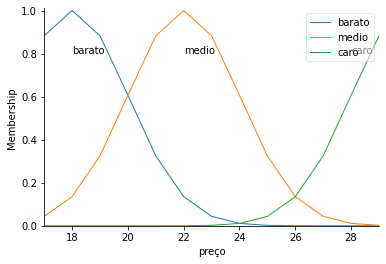

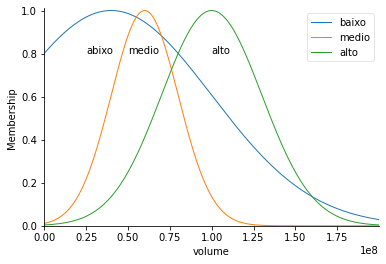

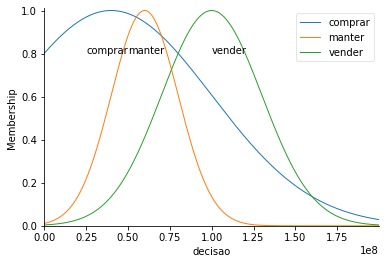

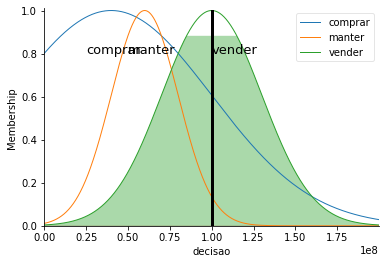

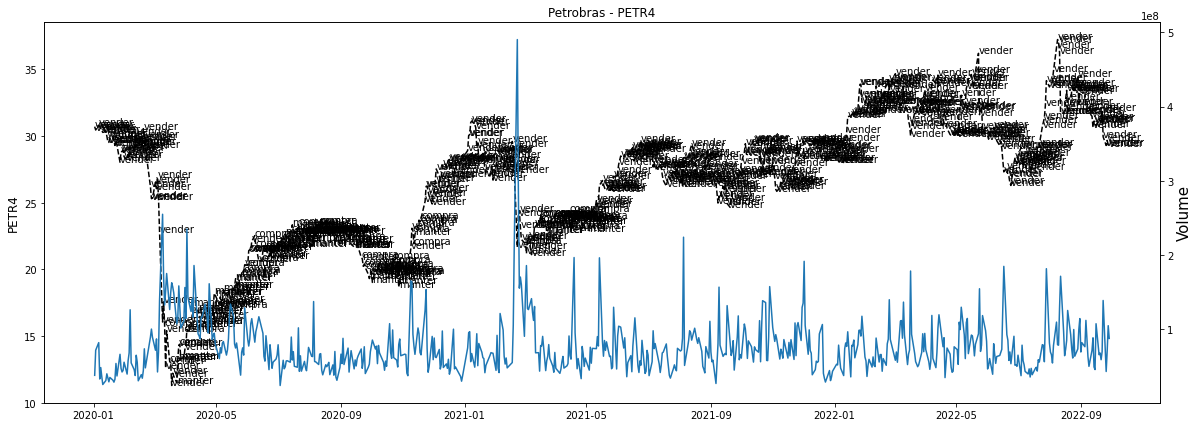

NameError: name 'Footer' is not defined

In [16]:
import datetime as dt
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns

#+++++++++++++++++ eixo das abscissas para as fun. pertinencias ++++++++++++++++++++
preco = ctl.Antecedent(np.arange(17,30,1), 'preço')
vol = ctl.Antecedent(np.arange(0,2e8,1e5), 'volume')
dec = ctl.Consequent(np.arange(0,2e8,1e5), 'decisao')

#++++++++++++++++++++ precos +++++++++++++++++++++++++
preco['barato'] = fuzz.gaussmf(preco.universe, 18,2)
preco['medio'] = fuzz.gaussmf(preco.universe, 22,2)
preco['caro'] = fuzz.gaussmf(preco.universe, 30, 2)
preco.view()
plt.text(x=18, y=0.8, s='barato', fontsize=10)
plt.text(x=22, y=0.8, s='medio', fontsize=10)
plt.text(x=28, y=0.8, s='caro', fontsize=10)

#++++++++++++++++++++volume+++++++++++++++++++++++++++++
vol['baixo'] = fuzz.gaussmf(vol.universe,0.4e8,6e7)
vol['medio'] = fuzz.gaussmf(vol.universe,0.6e8,2e7)
vol['alto'] = fuzz.gaussmf(vol.universe,1e8,3e7)
vol.view()
plt.text(x=0.25e8, y=0.8, s='abixo', fontsize=10)
plt.text(x=0.5e8, y=0.8, s='medio', fontsize=10)
plt.text(x=1e8, y=0.8, s='alto', fontsize=10)

#+++++++++++++++++++decisao de compra +++++++++++++++++++++
dec['comprar'] = fuzz.gaussmf(dec.universe,0.4e8,6e7)
dec['manter'] = fuzz.gaussmf(dec.universe,0.6e8,2e7)
dec['vender'] = fuzz.gaussmf(dec.universe,1e8,3e7)
dec.view()
plt.text(x=0.25e8, y=0.8, s='comprar', fontsize=10)
plt.text(x=0.5e8, y=0.8, s='manter', fontsize=10)
plt.text(x=1e8, y=0.8, s='vender', fontsize=10)

#+++++++++++++++ logica de compra e venda +++++++++++++++++++
regra1 = ctl.Rule(preco['barato'] & vol['baixo'], dec['comprar'])
regra2 = ctl.Rule(preco['barato'] & vol['alto'], dec['comprar'])
regra3 = ctl.Rule(preco['medio'] & vol['baixo'], dec['comprar'])
regra4 = ctl.Rule(preco['medio'] & vol['medio'], dec['manter'])
regra5 = ctl.Rule(preco['medio'] & vol['alto'], dec['vender'])
regra6 = ctl.Rule(preco['caro'] & vol['alto'], dec['vender'])

#++++++++++++++ controle +++++++++++++
decisao_ctl=ctl.ControlSystem([regra1,regra2,regra3,regra4,regra5,regra6])
decisao=ctl.ControlSystemSimulation(decisao_ctl)

#+++++++++++++ funcao de calculo defuzz ++++++++++++++
def indFz(entrada):
    #input
    print(entrada)
    decisao.input['preço'] = entrada[0]
    decisao.input['volume'] = entrada[1]
    #output
    decisao.compute()
    return (decisao.output['decisao'])

#+++++++++++++++++ aplicação ++++++++++++++++++++++++
data = yf.download("PETR4.SA", start="2020-01-01", end="2022-09-30")
#+++++++++++++++++ decisao final +++++++++++++++++++++
mval = np.zeros((len(data),3))
for i in range(len(data)):
    res1 = indFz([data['Close'].values[i],data['Volume'].values[i]])
    j=0
    for t in dec.terms:
        s = np.interp(res1, dec.universe, dec[t].mf)
        mval[i,j] = s
        j=j+1
mval = pd.DataFrame(mval, columns=['compra', 'manter', 'vender'])
dec_fuzz = mval.idxmax(axis=1)
print('+++++ decisao final ++++++')
print(dec_fuzz)
print('++++++++++++++++++++++++++')

dec.view(sim=decisao)
plt.text(x=0.25e8, y=0.8, s='comprar', fontsize=13)
plt.text(x=0.5e8, y=0.8, s='manter', fontsize=13)
plt.text(x=1e8, y=0.8, s='vender', fontsize=13)
plt.show()

figura=plt.figure(figsize=(20, 7))
ax1=plt.subplot(111)
plt.title('Petrobras - PETR4')
ax1.plot(data.index, data['Close'], '--k')
ax1.set_ylabel('PETR4', fontsize=12)
for i in range(len(dec_fuzz)):
    ax1.text(x=data.index[i], y=data['Close'].values[i], s=str(dec_fuzz[i]), fontsize=10)

ax2 = ax1.twinx()
ax2.plot(data.index, data['Volume'])
ax2.set_ylabel('Volume', fontsize=15)
plt.show()
Footer

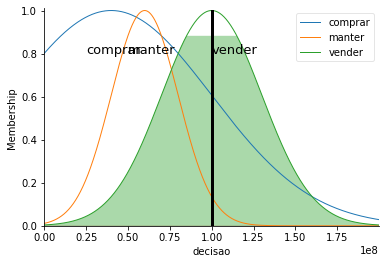

In [7]:
dec.view(sim=decisao)
plt.text(x=0.25e8, y=0.8, s='comprar', fontsize=13)
plt.text(x=0.5e8, y=0.8, s='manter', fontsize=13)
plt.text(x=1e8, y=0.8, s='vender', fontsize=13)
plt.show()

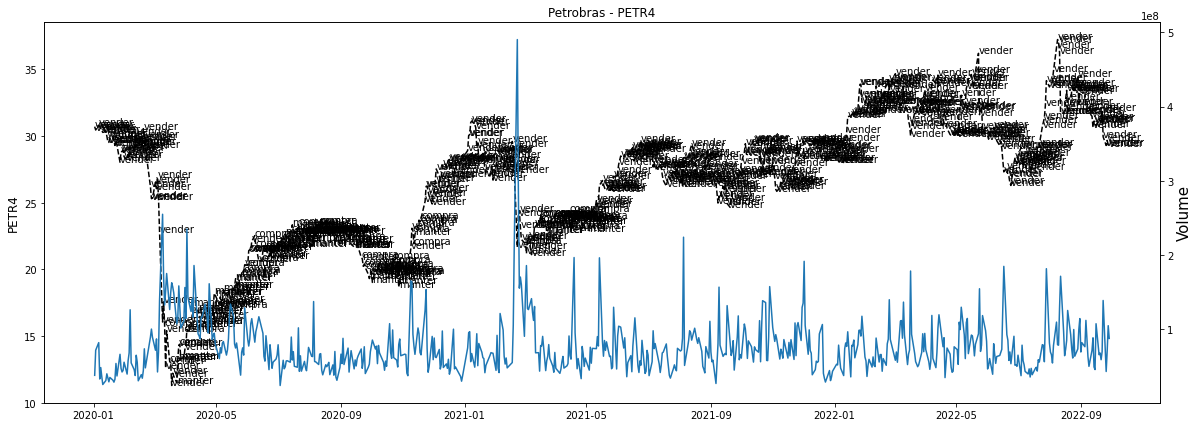

In [14]:
figura=plt.figure(figsize=(20, 7))
ax1=plt.subplot(111)
plt.title('Petrobras - PETR4')
ax1.plot(data.index, data['Close'], '--k')
ax1.set_ylabel('PETR4', fontsize=12)
for i in range(len(dec_fuzz)):
    ax1.text(x=data.index[i], y=data['Close'].values[i], s=str(dec_fuzz[i]), fontsize=10)
ax2 = ax1.twinx()
ax2.plot(data.index, data['Volume'])
ax2.set_ylabel('Volume', fontsize=15)
plt.show()